# Что мы будем разбирать?

* 1. Какие бывают данные?
* 2. Откуда брать данные?
* 3. Методы сбора и хранения данных?
* 4. Принцип работы: REST API и Websocket API
* 5. Скачаем данные и покрутим

# Мы разбираем только Bybit биржу, подозреваю, что у других бирж +- тоже самое

# 1. Какие бывают данные?

## 1.1 Данные о ценах и графиках (Kline/Свечи)

* Стандартные Kline: исторические данные о ценах в формате OHLC (Open, High, Low, Close) с различными временными интервалами
* Mark Price Kline: данные о цене маркировки (используется для расчетов ликвидации)
* Index Price Kline: данные об индексной цене (используется как ориентир для расчетов)
* Premium Index Price Kline: данные о премиальном индексе (для расчета ставки финансирования)

## 1.2 Текущие рыночные данные

* Tickers: последние моментальные данные о ценах, лучших ценах покупки/продажи и объемах торгов за последние 24 часа
* Orderbook: текущий биржевой стакан с ценами и объемами
* Recent Trades: недавние сделки на бирже

## 1.3 Производные данные

* Funding Rate History: историческая ставка финансирования (для контрактов с бессрочным сроком)
* Open Interest: открытый интерес (количество открытых позиций) по инструментам
* Historical Volatility: историческая волатильность
* Long Short Ratio: соотношение длинных и коротких позиций
* Insurance: данные по страховому фонду
* Risk Limit: информация о лимитах риска
* Delivery Price: цены поставки для фьючерсных контрактов

# 2. Откуда брать данные?

## 2.1 Bybit

### Доступ к данным и особенности API

API v5 объединяет все типы продуктов (спот, деривативы, опционы) в единый набор спецификаций
Параметр category позволяет указать тип рынка: spot (спот), linear (линейные контракты), inverse (обратные контракты) или option (опционы)
Рекомендуется использовать WebSocket для получения рыночных данных в реальном времени, так как эти запросы не учитываются в ограничениях на количество запросов
REST API используется для получения исторических данных и выполнения операций

### Форматы и параметры данных
Для каждого типа данных существуют свои специфические параметры. Например, для Kline данных можно указать:

* symbol: торговая пара (например, BTCUSDT)
* interval: временной интервал (1, 3, 5, 15, 30, 60, 120, 240, 360, 720, D, W, M)
* start и end: временной диапазон (в миллисекундах)


## 2.2 Сервисы

* Kaiko - https://www.kaiko.com/
* Tardis - https://tardis.dev/

# 3. Методы сбора данных

## 3.1 Сбор данных
* API Bybit
* Kaiko / Tardis

## 3.2 Хранение
Хранение даты, временных рядов:
* Timescale - https://www.timescale.com/
* InfluxData - https://www.influxdata.com/index/

Для структурных данных:
* PostgreSQL - https://www.postgresql.org/

## 3.3 Обработка

### Неочищенные данные (raw data):
- Исходные данные прямо с источника без обработки
- Могут содержать аномалии: выбросы, недостающие значения, неправильные тики
- Включают технические ошибки: повторы данных, неправильные временные метки
- Примеры: дублирующие трейды, нулевые объемы, аномальные проскальзования цен

### Очищенные данные (cleaned Data):
- Обработанные данные после процедур фильтрации и коррекции
- Устранены очевидные ошибки: удалены выбросы, исправлены сдвиги временных меток
- Заполнены пропуски: интерполированы отсустствующие значения
- Исправлены структурные проблемы: обработаны кроссс-биржевые различия, стандартизированы форматы

### 3.4 Аналитика данных
* Tableau - https://www.tableau.com/
* Power BI - https://www.microsoft.com/en-us/power-platform/products/power-bi
* Jupyter
* Возможно Grafana - https://grafana.com/

# 4. Принцип работы

### Цель REST API:
REST API на Bybit используется для выполнения отдельных конкретных действий, которые не требуют постоянного соединения. Его основная цель - предоставить способ для программного взаимодействия с биржей через стандартные HTTP-запросы.

### Цель WebSocket API:
WebSocket API предназначен для получения данных в реальном времени и обеспечения двусторонней связи с минимальной задержкой. Его основная цель - предоставить эффективный канал для постоянного обновления данных без необходимости отправки новых запросов.


### REST API: 
Работает по модели "запрос-ответ". Каждый запрос требует нового HTTP-соединения, которое закрывается после получения ответа. Это статический, не поддерживающий состояние подход.
### WebSocket API: 
Обеспечивает постоянное двустороннее соединение между клиентом и сервером. После установки соединения данные могут передаваться в обоих направлениях без необходимости создания новых запросов.

# К примерам

* Заходим - https://www.bybit.com/future-activity/en/developer
* Открываем - https://bybit-exchange.github.io/docs/v5/intro

In [39]:
from IPython.display import Image

Image(url='https://vezgo.com/blog/wp-content/uploads/2024/03/Bybit-documentation-1024x603.png')


# 5. Примеры

### 5.1 Скачивание данных через REST API Bybit
* Свечки
* Актив: BTCUSDT
* Таймфрейм: 1m
* Дата: 19.05.2025-19.05.2025

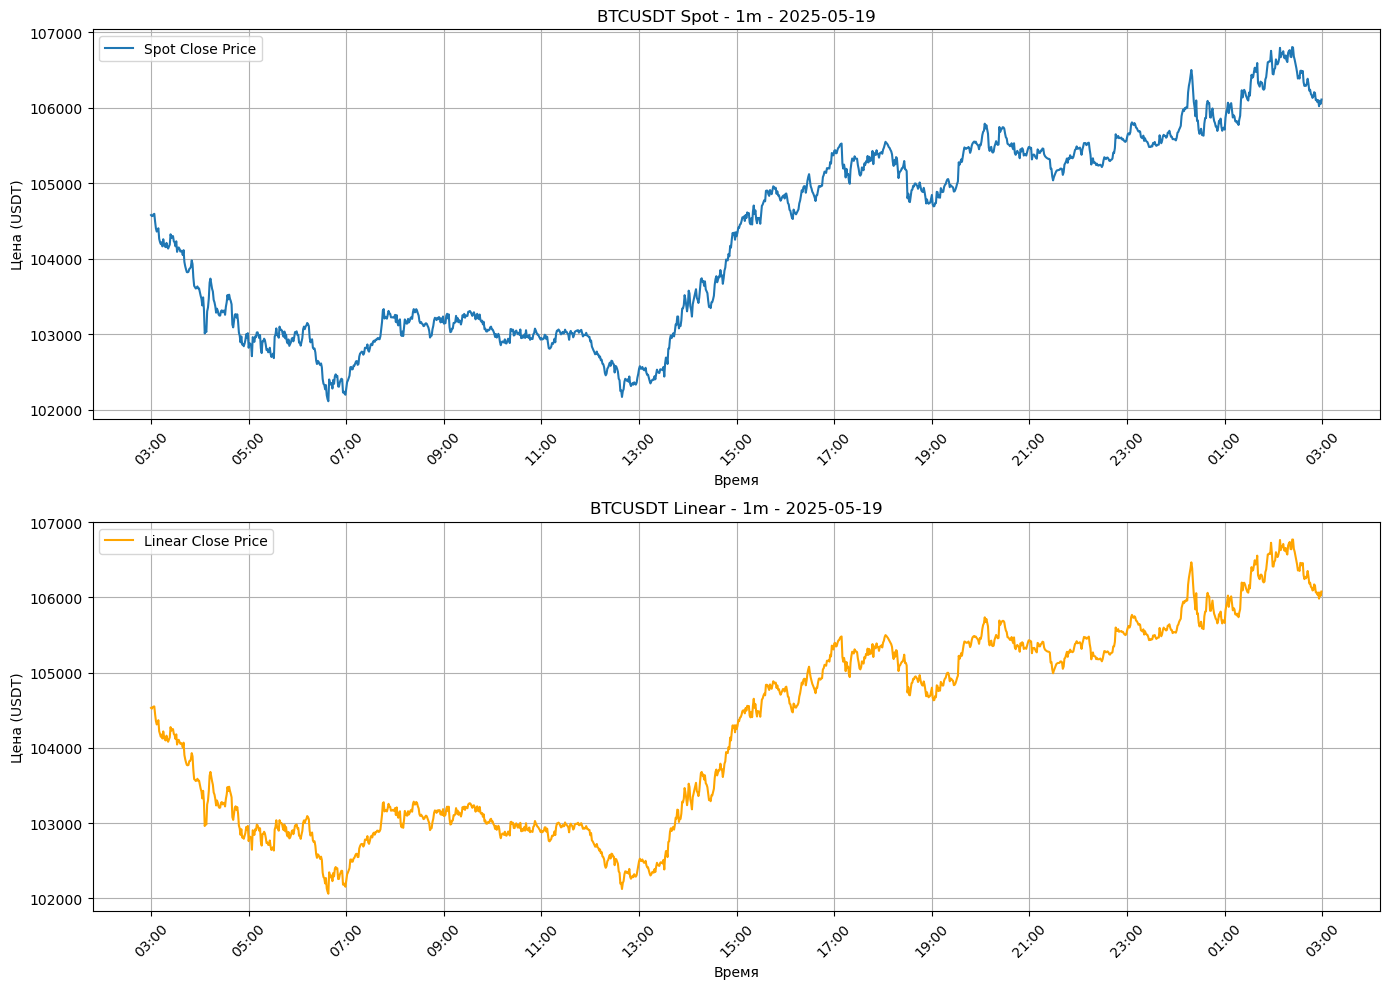

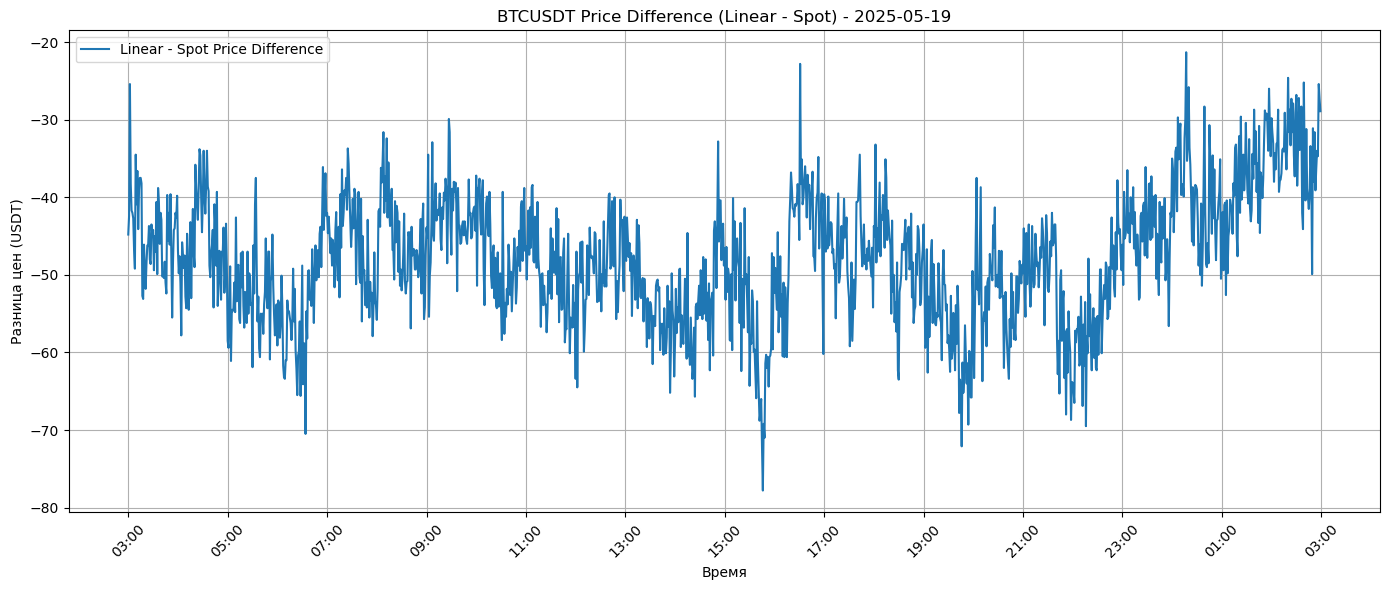

Данные успешно загружены и сохранены в файлы.
Количество свечей spot: 1440
Количество свечей linear: 1440


In [3]:
import pandas as pd
import numpy as np
import requests
import json
import hmac
import hashlib
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# API ключи
api_key = ""
api_secret = ""

# Параметры запроса
symbol = "BTCUSDT"
interval = "1"  # 1 минута
start_time = int(datetime(2025, 5, 19, 0, 0, 0).timestamp() * 1000)  # 19.05.2025 00:00:00
end_time = int(datetime(2025, 5, 19, 23, 59, 59).timestamp() * 1000)  # 19.05.2025 23:59:59

# Функция для генерации подписи для аутентификации
def generate_signature(api_secret, params):
    sorted_params = sorted(params.items())
    signature_string = '&'.join([f"{key}={value}" for key, value in sorted_params])
    return hmac.new(api_secret.encode('utf-8'), signature_string.encode('utf-8'), hashlib.sha256).hexdigest()

# Функция для получения данных свечей
def get_klines(category, interval, symbol, start_time, end_time):
    base_url = "https://api.bybit.com"
    endpoint = "/v5/market/kline"
    
    timestamp = int(time.time() * 1000)
    params = {
        "category": category,
        "symbol": symbol,
        "interval": interval,
        "start": start_time,
        "end": end_time,
        "limit": 1000,  # максимальное количество свечей в ответе
    }
    
    # Подписываем запрос
    sign_params = params.copy()
    sign_params["api_key"] = api_key
    sign_params["timestamp"] = timestamp
    signature = generate_signature(api_secret, sign_params)
    
    # Добавляем подпись и другие параметры в заголовки
    headers = {
        "X-BAPI-API-KEY": api_key,
        "X-BAPI-SIGN": signature,
        "X-BAPI-TIMESTAMP": str(timestamp),
        "X-BAPI-RECV-WINDOW": "5000"
    }
    
    all_klines = []
    
    # Делаем запрос
    response = requests.get(f"{base_url}{endpoint}", params=params, headers=headers)
    data = response.json()
    
    if data["retCode"] == 0 and "result" in data and "list" in data["result"]:
        klines = data["result"]["list"]
        all_klines.extend(klines)
        
        # Если нужно получить больше данных, можно сделать пагинацию
        while len(klines) == 1000:
            # Изменяем end_time на время последней полученной свечи минус 1 мс
            end_time = int(klines[-1][0]) - 1
            params["end"] = end_time
            
            # Обновляем подпись
            sign_params = params.copy()
            sign_params["api_key"] = api_key
            sign_params["timestamp"] = int(time.time() * 1000)
            signature = generate_signature(api_secret, sign_params)
            headers["X-BAPI-SIGN"] = signature
            headers["X-BAPI-TIMESTAMP"] = str(sign_params["timestamp"])
            
            response = requests.get(f"{base_url}{endpoint}", params=params, headers=headers)
            data = response.json()
            
            if data["retCode"] == 0 and "result" in data and "list" in data["result"]:
                klines = data["result"]["list"]
                all_klines.extend(klines)
            else:
                print(f"Ошибка при получении данных: {data}")
                break
    else:
        print(f"Ошибка при получении данных: {data}")
    
    return all_klines

# Получаем данные для spot и linear рынков
spot_klines = get_klines("spot", interval, symbol, start_time, end_time)
linear_klines = get_klines("linear", interval, symbol, start_time, end_time)

# Преобразуем данные в DataFrame
def klines_to_dataframe(klines):
    df = pd.DataFrame(klines, columns=["timestamp", "open", "high", "low", "close", "volume", "turnover"])
    # Преобразуем типы данных
    for col in ["open", "high", "low", "close", "volume", "turnover"]:
        df[col] = pd.to_numeric(df[col])
    
    # Исправленный код: сначала преобразуем timestamp в числовой тип, а затем в datetime
    # Это устраняет FutureWarning о параметре unit
    df["timestamp"] = pd.to_numeric(df["timestamp"])
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
    
    return df

spot_df = klines_to_dataframe(spot_klines)
linear_df = klines_to_dataframe(linear_klines)

# Сохраняем данные в CSV файлы
spot_df.to_csv(f"{symbol}_spot_{interval}m_{datetime.fromtimestamp(start_time/1000).strftime('%Y%m%d')}.csv", index=False)
linear_df.to_csv(f"{symbol}_linear_{interval}m_{datetime.fromtimestamp(start_time/1000).strftime('%Y%m%d')}.csv", index=False)

# Визуализация данных
plt.figure(figsize=(14, 10))

# График для spot
plt.subplot(2, 1, 1)
plt.plot(spot_df["timestamp"], spot_df["close"], label="Spot Close Price")
plt.title(f"{symbol} Spot - 1m - {datetime.fromtimestamp(start_time/1000).strftime('%Y-%m-%d')}")
plt.xlabel("Время")
plt.ylabel("Цена (USDT)")
plt.grid(True)
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=2))
plt.xticks(rotation=45)

# График для linear
plt.subplot(2, 1, 2)
plt.plot(linear_df["timestamp"], linear_df["close"], label="Linear Close Price", color="orange")
plt.title(f"{symbol} Linear - 1m - {datetime.fromtimestamp(start_time/1000).strftime('%Y-%m-%d')}")
plt.xlabel("Время")
plt.ylabel("Цена (USDT)")
plt.grid(True)
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=2))
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig(f"{symbol}_comparison_{interval}m_{datetime.fromtimestamp(start_time/1000).strftime('%Y%m%d')}.png")
plt.show()

# Дополнительные графики для анализа разницы между spot и linear
if not spot_df.empty and not linear_df.empty:
    # Приводим данные к общему временному интервалу через ресемплирование
    spot_df.set_index('timestamp', inplace=True)
    linear_df.set_index('timestamp', inplace=True)
    
    # Находим общий диапазон дат
    common_dates = spot_df.index.intersection(linear_df.index)
    
    if len(common_dates) > 0:
        # Выбираем только общие даты
        spot_common = spot_df.loc[common_dates]
        linear_common = linear_df.loc[common_dates]
        
        # Вычисляем разницу
        price_diff = linear_common['close'] - spot_common['close']
        
        # Строим график разницы
        plt.figure(figsize=(14, 6))
        plt.plot(price_diff.index, price_diff, label="Linear - Spot Price Difference")
        plt.title(f"{symbol} Price Difference (Linear - Spot) - {datetime.fromtimestamp(start_time/1000).strftime('%Y-%m-%d')}")
        plt.xlabel("Время")
        plt.ylabel("Разница цен (USDT)")
        plt.grid(True)
        plt.legend()
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=2))
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f"{symbol}_price_diff_{interval}m_{datetime.fromtimestamp(start_time/1000).strftime('%Y%m%d')}.png")
        plt.show()

print(f"Данные успешно загружены и сохранены в файлы.")
print(f"Количество свечей spot: {len(spot_df)}")
print(f"Количество свечей linear: {len(linear_df)}")

Использовали REST API Bybit, а не WebSocket API. REST API больше подходит для ретроспективного анализа исторических данных за определенный период, тогда как WebSocket API больше подходит для потоковой передачи данных в реальном времени

## Компоненты кода:

* ### 1. Аутентификация и подпись запросов:

* Bybit требует подписывать запросы с помощью HMAC-SHA256
* Функция generate_signature создает подпись на основе API-секрета и упорядоченных параметров


* ### 2. Получение данных о свечах:

* Функция get_klines отправляет запросы к эндпоинту /v5/market/kline
* Реализована пагинация для получения всех данных за указанный период
* Отдельные запросы для spot и linear рынков


* ### 3. Обработка данных:

* Преобразование данных из JSON в DataFrame с помощью pandas
* Преобразование типов данных (числовые значения и временные метки)


* ### 4. Сохранение данных:

* Данные сохраняются в CSV файлы для последующего использования
* Создаются отдельные файлы для spot и linear рынков


* ### 5. Визуализация:

* Построение графиков с помощью matplotlib
* Отдельные графики для spot и linear цен
* Дополнительный график разницы цен между spot и linear рынками



## Особенности REST API Bybit:

* Эндпоинт: /v5/market/kline используется для получения исторических данных о свечах

### Параметры запроса:
* category: тип рынка (spot или linear)
* symbol: торговая пара (BTCUSDT)
* interval: таймфрейм (1 минута)
* start и end: временной диапазон в миллисекундах
* limit: максимальное количество свечей в ответе (по умолчанию 1000)


#### Ограничения:
* За один запрос можно получить максимум 1000 свечей
* Для получения большего количества данных нужно делать несколько запросов с изменением временного диапазона

# Анализ собранных данных и обработка

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Настройка визуального стиля
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Путь к файлу
file_path = 'BTCUSDT_linear_1m_20250519.csv'

# 1. Загрузка данных
def load_data(file_path):
    try:
        # Пробуем загрузить как CSV
        df = pd.read_csv(file_path, parse_dates=['timestamp'])
    except Exception as e:
        # Если не получилось, пробуем загрузить как Excel
        try:
            df = pd.read_excel(file_path, parse_dates=['timestamp'])
        except Exception as e:
            print(f"Ошибка при загрузке файла: {e}")
            return None
    
    print(f"Данные успешно загружены. Размер: {df.shape}")
    return df

# 2. Анализ пропусков в данных
def analyze_missing_values(df):
    print("\n=== 1. АНАЛИЗ ПРОПУСКОВ В ДАННЫХ ===")
    text1 = """На этом этапе мы:
        1 - Использовали `df.isnull().sum()` для подсчета пропущенных значений в каждом столбце
        2 - Отсортировали данные по времени и вычислили временные интервалы между записями
        3 - Проверили непрерывность временного ряда, ища интервалы больше 1 минуты
        4 - Сравнили ожидаемое количество записей (24 часа × 60 минут = 1440) с фактическим
        
        Результат: пропусков не обнаружено - все ячейки заполнены, временной ряд непрерывный."""

    print(text1)
    
    # Проверка на пропущенные значения
    missing_values = df.isnull().sum()
    print(f"Пропущенные значения по столбцам:\n{missing_values}")
    
    # Проверка на полноту временного ряда
    df = df.sort_values('timestamp')
    
    # Проверяем, есть ли минутные интервалы между последовательными временными метками
    time_diffs = df['timestamp'].diff().dt.total_seconds() / 60
    missing_intervals = time_diffs[time_diffs > 1]
    
    if len(missing_intervals) > 0:
        print(f"\nНайдено {len(missing_intervals)} пропущенных интервалов во временных метках:")
        for idx in missing_intervals.index:
            prev_time = df.loc[idx-1, 'timestamp']
            curr_time = df.loc[idx, 'timestamp']
            gap_minutes = (curr_time - prev_time).total_seconds() / 60
            print(f"Пропуск между {prev_time} и {curr_time} ({gap_minutes} минут)")
    else:
        print("\nПропусков в последовательности временных меток не обнаружено.")
    
    # Проверка ожидаемого количества записей
    start_time = df['timestamp'].min()
    end_time = df['timestamp'].max()
    expected_records = int((end_time - start_time).total_seconds() / 60) + 1
    
    print(f"\nВременной диапазон данных: с {start_time} по {end_time}")
    print(f"Ожидаемое количество записей: {expected_records}")
    print(f"Фактическое количество записей: {len(df)}")
    
    if expected_records > len(df):
        print(f"Отсутствует {expected_records - len(df)} записей")
    
    return df

# 3. Анализ аномальных значений
def analyze_anomalies(df):
    print("\n=== 2. АНАЛИЗ АНОМАЛЬНЫХ ЗНАЧЕНИЙ ===")
    text2 = """На этом этапе мы:
    1 - Рассчитали базовую статистику для всех числовых столбцов
    2 - Применили метод межквартильного размаха (IQR) для выявления выбросов:
      • Вычислили Q1 (25-й перцентиль) и Q3 (75-й перцентиль)
      • Рассчитали IQR = Q3 - Q1
      • Определили границы: нижняя = Q1 - 1.5×IQR, верхняя = Q3 + 1.5×IQR

    3 - Обнаружили выбросы в каждом числовом столбце (open, high, low, close, volume, turnover)
    4 - Проанализировали размах свечей (разница high-low)
    5 - Вычислили процентное изменение цены между свечами
    6 - Выявили свечи с экстремальными движениями цены

    Результат: обнаружены значительные отклонения в ценах и объемах, но они соответствуют нормальной волатильности криптовалютного рынка."""

    print(text2)
    
    # Статистика по числовым столбцам
    numeric_cols = ['open', 'high', 'low', 'close', 'volume', 'turnover']
    
    print("\nСтатистика по числовым столбцам:")
    stats = df[numeric_cols].describe(percentiles=[.01, .05, .25, .75, .95, .99]).T
    print(stats)
    
    # Выявление выбросов с помощью метода IQR (межквартильный размах)
    anomalies = {}
    
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        anomalies[col] = outliers
        
        print(f"\nВыбросы в столбце {col}: {len(outliers)} записей")
        print(f"Границы для выбросов: [{lower_bound:.2f}, {upper_bound:.2f}]")
        
        if len(outliers) > 0 and len(outliers) <= 5:
            print("Примеры выбросов:")
            print(outliers[['timestamp', col]].head())
    
    # Анализ аномально больших свечей
    df['candle_range'] = df['high'] - df['low']
    df['candle_range_pct'] = (df['candle_range'] / df['low']) * 100
    
    # Выбросы по размеру свечи
    Q1 = df['candle_range'].quantile(0.25)
    Q3 = df['candle_range'].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    
    large_candles = df[df['candle_range'] > upper_bound].sort_values('candle_range', ascending=False)
    
    print(f"\nАномально большие свечи (по абсолютному размаху): {len(large_candles)} записей")
    if len(large_candles) > 0:
        print("Топ-5 самых больших свечей:")
        print(large_candles[['timestamp', 'open', 'high', 'low', 'close', 'candle_range']].head(5))
    
    # Аномальные изменения цены между свечами
    df['price_change'] = df['close'].pct_change() * 100
    
    Q1 = df['price_change'].quantile(0.25)
    Q3 = df['price_change'].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 3 * IQR  # Используем 3*IQR для выявления очень сильных движений
    upper_bound = Q3 + 3 * IQR
    
    extreme_changes = df[(df['price_change'] < lower_bound) | (df['price_change'] > upper_bound)]
    extreme_changes = extreme_changes.sort_values('price_change', key=abs, ascending=False)
    
    print(f"\nЭкстремальные изменения цены между свечами: {len(extreme_changes)} записей")
    if len(extreme_changes) > 0:
        print("Топ-5 самых экстремальных изменений цены:")
        print(extreme_changes[['timestamp', 'close', 'price_change']].head(5))
    
    return df, anomalies

# 4. Анализ несогласованности в OHLC данных
def analyze_ohlc_consistency(df):
    print("\n=== 3. АНАЛИЗ НЕСОГЛАСОВАННОСТИ В OHLC ДАННЫХ ===")
    text3 = """Мы проверили логическую согласованность данных:
    1 - Проверили, что high ≥ open и high ≥ close
    2 - Проверили, что low ≤ open и low ≤ close
    3 - Проверили, что high ≥ low
    4 - Рассчитали среднюю цену двумя способами:
      • Средняя из OHLC: (open + high + low + close) / 4
      • Средняя из оборота: turnover / volume
    5 - Сравнили эти значения для выявления несоответствий
    
    Результат: несогласованностей в OHLC данных не обнаружено - все свечи соответствуют логическим ограничениям."""
    
    print(text3)

    
    # Проверка: high должен быть >= open и close
    high_inconsistent = df[(df['high'] < df['open']) | (df['high'] < df['close'])]
    
    # Проверка: low должен быть <= open и close
    low_inconsistent = df[(df['low'] > df['open']) | (df['low'] > df['close'])]
    
    # Проверка: high должен быть >= low
    high_low_inconsistent = df[df['high'] < df['low']]
    
    print(f"Несогласованность high < open или high < close: {len(high_inconsistent)} записей")
    if len(high_inconsistent) > 0:
        print("Примеры несогласованности high:")
        print(high_inconsistent[['timestamp', 'open', 'high', 'low', 'close']].head())
    
    print(f"\nНесогласованность low > open или low > close: {len(low_inconsistent)} записей")
    if len(low_inconsistent) > 0:
        print("Примеры несогласованности low:")
        print(low_inconsistent[['timestamp', 'open', 'high', 'low', 'close']].head())
    
    print(f"\nНесогласованность high < low: {len(high_low_inconsistent)} записей")
    if len(high_low_inconsistent) > 0:
        print("Примеры несогласованности high-low:")
        print(high_low_inconsistent[['timestamp', 'open', 'high', 'low', 'close']].head())
    
    # Проверка согласованности объемов и оборота
    df['avg_price_by_turnover'] = df['turnover'] / df['volume']
    df['avg_price_ohlc'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    df['price_consistency_ratio'] = df['avg_price_by_turnover'] / df['avg_price_ohlc']
    
    # Выявление несогласованности (отклонение более 1%)
    price_inconsistent = df[(df['price_consistency_ratio'] < 0.99) | (df['price_consistency_ratio'] > 1.01)]
    
    print(f"\nНесогласованность между средней ценой из turnover/volume и OHLC: {len(price_inconsistent)} записей")
    if len(price_inconsistent) > 0:
        print("Примеры несогласованности цен:")
        print(price_inconsistent[['timestamp', 'avg_price_by_turnover', 'avg_price_ohlc', 'price_consistency_ratio']].head())
    
    return df

# 5. Анализ дубликатов данных
def analyze_duplicates(df):
    print("\n=== 4. АНАЛИЗ ДУБЛИКАТОВ ДАННЫХ ===")
    text4 = """Затем мы искали повторяющиеся записи:
        1 - Проверили наличие полных дубликатов (все поля совпадают)
        2 - Проверили наличие дубликатов по временной метке (timestamp)

        Результат: дубликатов не обнаружено - каждая запись уникальна, временные метки не повторяются."""
    
    print(text4)
    
    # Проверка дубликатов по всем столбцам
    full_duplicates = df[df.duplicated()]
    print(f"Полные дубликаты (все столбцы): {len(full_duplicates)} записей")
    
    if len(full_duplicates) > 0:
        print("Примеры полных дубликатов:")
        print(full_duplicates.head())
    
    # Проверка дубликатов только по временной метке
    timestamp_duplicates = df[df.duplicated('timestamp', keep=False)]
    print(f"\nДубликаты по временной метке: {len(timestamp_duplicates)} записей")
    
    if len(timestamp_duplicates) > 0:
        print("Примеры дубликатов по временной метке:")
        print(timestamp_duplicates.sort_values('timestamp').head())
    
    return df

# 6. Визуализация данных для анализа
def visualize_data(df):
    print("\n=== ВИЗУАЛИЗАЦИЯ ДАННЫХ ДЛЯ АНАЛИЗА ===")
    
    # Создаем фигуры и оси
    fig, axes = plt.subplots(3, 1, figsize=(12, 18), gridspec_kw={'height_ratios': [3, 1, 1]})
    
    # График цен (OHLC)
    axes[0].plot(df['timestamp'], df['close'], label='Close Price')
    axes[0].set_title('Цена закрытия BTCUSDT')
    axes[0].set_ylabel('Цена (USD)')
    axes[0].legend()
    
    # График объемов
    axes[1].bar(df['timestamp'], df['volume'], color='blue', alpha=0.7)
    axes[1].set_title('Объем торгов')
    axes[1].set_ylabel('Объем')
    
    # График процентного изменения цены
    axes[2].plot(df['timestamp'], df['price_change'], color='green')
    axes[2].axhline(y=0, color='red', linestyle='-', alpha=0.3)
    axes[2].set_title('Процентное изменение цены')
    axes[2].set_ylabel('Изменение (%)')
    axes[2].set_xlabel('Время')
    
    plt.tight_layout()
    plt.savefig('btcusdt_analysis.png')
    plt.close()
    
    # Гистограммы распределения
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Распределение объемов
    sns.histplot(df['volume'], bins=50, kde=True, ax=axes[0, 0])
    axes[0, 0].set_title('Распределение объемов')
    
    # Распределение размаха свечей
    sns.histplot(df['candle_range'], bins=50, kde=True, ax=axes[0, 1])
    axes[0, 1].set_title('Распределение размаха свечей')
    
    # Распределение изменения цены
    sns.histplot(df['price_change'], bins=50, kde=True, ax=axes[1, 0])
    axes[1, 0].set_title('Распределение изменения цены')
    
    # Box plot для числовых столбцов
    sns.boxplot(data=df[['open', 'high', 'low', 'close']], ax=axes[1, 1])
    axes[1, 1].set_title('Box plot цен')
    
    plt.tight_layout()
    plt.savefig('btcusdt_distributions.png')
    plt.close()
    
    print("Визуализации сохранены в файлы btcusdt_analysis.png и btcusdt_distributions.png")

# Основная функция
def main():
    # Загружаем данные
    df = load_data(file_path)
    
    if df is None:
        print("Не удалось загрузить данные. Проверьте путь к файлу и формат данных.")
        return
    
    # Выводим информацию о структуре данных
    print("\nСтруктура данных:")
    print(df.info())
    
    print("\nПервые 5 строк данных:")
    print(df.head())
    
    # Анализ пропусков
    df = analyze_missing_values(df)
    
    # Анализ аномальных значений
    df, anomalies = analyze_anomalies(df)
    
    # Анализ несогласованности в OHLC
    df = analyze_ohlc_consistency(df)
    
    # Анализ дубликатов
    df = analyze_duplicates(df)
    
    # Визуализация
    visualize_data(df)
    
    print("\n=== ВЫВОДЫ ПО АНАЛИЗУ КАЧЕСТВА ДАННЫХ ===")
    print("1. Пропуски в данных: [заполнится по результатам анализа]")
    print("2. Аномальные значения: [заполнится по результатам анализа]")
    print("3. Несогласованность в OHLC данных: [заполнится по результатам анализа]")
    print("4. Дубликаты данных: [заполнится по результатам анализа]")

if __name__ == "__main__":
    main()

Данные успешно загружены. Размер: (1440, 7)

Структура данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  1440 non-null   datetime64[ns]
 1   open       1440 non-null   float64       
 2   high       1440 non-null   float64       
 3   low        1440 non-null   float64       
 4   close      1440 non-null   float64       
 5   volume     1440 non-null   float64       
 6   turnover   1440 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 78.9 KB
None

Первые 5 строк данных:
            timestamp      open      high       low     close   volume  \
0 2025-05-20 02:59:00  106023.1  106079.6  106023.1  106079.1   41.801   
1 2025-05-20 02:58:00  106066.4  106066.4  106023.1  106023.1   23.441   
2 2025-05-20 02:57:00  105985.3  106066.4  105964.0  106066.4   62.816   
3 2025-05-20 02:56:00  

## Межквартильный размах (IQR)
Межквартильный размах (Interquartile Range, IQR) — это статистическая мера разброса данных, которая показывает разницу между третьим (Q3) и первым (Q1) квартилями распределения:

$IQR = Q3 - Q1$

### Основные концепции:

#### Квартили — это значения, которые делят отсортированный набор данных на четыре равные части:
* Q1 (первый квартиль) — значение, ниже которого находится 25% данных
* Q2 (второй квартиль или медиана) — значение, ниже которого находится 50% данных
* Q3 (третий квартиль) — значение, ниже которого находится 75% данных

### Применение IQR:

#### Обнаружение выбросов: Наиболее распространенное применение IQR — определение статистических выбросов с помощью правила 1.5×IQR:

* Нижняя граница = Q1 - 1.5 × IQR
* Верхняя граница = Q3 + 1.5 × IQR
* Значения, выходящие за эти границы, считаются потенциальными выбросами

#### Пример:
Допустим, у нас есть набор чисел: [1, 3, 5, 7, 8, 9, 10, 11, 15, 18, 20]

* Q1 = 5 (25-й процентиль)
* Q3 = 15 (75-й процентиль)
* IQR = 15 - 5 = 10
* Нижняя граница для выбросов = 5 - 1.5 × 10 = -10
* Верхняя граница для выбросов = 15 + 1.5 × 10 = 30

### В данном примере ни одно из значений не выходит за границы [-10, 30], поэтому выбросов нет.

В анализе качества данных BTCUSDT я использовал IQR для выявления потенциальных аномалий в ценах и объемах торгов, что позволило определить нестандартные свечи, выходящие за пределы типичного диапазона.

## После того как мы выявили например аномалии, то можно использовать методы обработки некачественных данных

Лучше использовать сразу качественные, но если вдруг у нас они есть, то есть методы:

### 1 - Заполнение пропусков
* Интерполяция: Заполнение пропущенных значений на основе соседних точек
* Репликация предыдущих значений: Используя метод forward fill (ffill)
* Генерация синтетических свечей: Создание искусственных свечей на основе соседних данных

### 2 - Обработка аномалий

* Медианная фильтрация: Замена аномальных значений медианой соседних точек
* Винзоризация: Ограничение экстремальных значений определенными пределами
* Сглаживание: Применение скользящего среднего для сглаживания резких выбросов

### 3 - Исправление несогласованности OHLC
* Корректировка несогласованных значений: Исправление логических несоответствий в OHLC данных

### 4. Удаление дубликатов
* Удаление или объединение дублирующихся записей.

### 5.2 Скачивание данных через REST API Bybit
* Трейды
* Актив: BTCUSDT
* Таймфрейм: 1m
* Дата: 19.05.2025-19.05.2025

In [10]:
import requests
import pandas as pd
import time
import hmac
import hashlib
import json
from datetime import datetime

# Конфигурация API
api_key = ""
api_secret = ""
base_url = "https://api.bybit.com"

# Преобразование даты в timestamp (миллисекунды)
start_date = int(datetime.strptime("19.05.2025", "%d.%m.%Y").timestamp() * 1000)
end_date = int(datetime.strptime("19.05.2025", "%d.%m.%Y").timestamp() * 1000) + (24 * 60 * 60 * 1000 - 1)  # До конца дня

# Функция для создания подписи для аутентификации
def generate_signature(secret, params):
    param_str = ""
    # Сортировка параметров по имени
    for key in sorted(params.keys()):
        param_str += f"{key}={params[key]}&"
    param_str = param_str[:-1]  # Удаление последнего &
    
    return hmac.new(
        bytes(secret, "utf-8"),
        bytes(param_str, "utf-8"),
        hashlib.sha256
    ).hexdigest()

# Функция для получения исторических трейдов SPOT
def get_spot_trades(symbol, limit=1000):
    endpoint = "/v5/market/recent-trade"
    params = {
        "category": "spot",
        "symbol": symbol,
        "limit": limit,
        "timestamp": str(int(time.time() * 1000))
    }
    
    # Добавление аутентификации
    params["api_key"] = api_key
    params["recv_window"] = "5000"
    params["sign"] = generate_signature(api_secret, params)
    
    response = requests.get(f"{base_url}{endpoint}", params=params)
    data = response.json()
    
    if data["retCode"] == 0:
        trades = data["result"]["list"]
        df = pd.DataFrame(trades)
        return df
    else:
        print(f"Error: {data}")
        return None

# Функция для получения исторических трейдов Linear (фьючерсы)
def get_linear_trades(symbol, limit=1000):
    endpoint = "/v5/market/recent-trade"
    params = {
        "category": "linear",
        "symbol": symbol,
        "limit": limit,
        "timestamp": str(int(time.time() * 1000))
    }
    
    # Добавление аутентификации
    params["api_key"] = api_key
    params["recv_window"] = "5000"
    params["sign"] = generate_signature(api_secret, params)
    
    response = requests.get(f"{base_url}{endpoint}", params=params)
    data = response.json()
    
    if data["retCode"] == 0:
        trades = data["result"]["list"]
        df = pd.DataFrame(trades)
        return df
    else:
        print(f"Error: {data}")
        return None

# Получение трейдов
symbol = "BTCUSDT"
spot_trades = get_spot_trades(symbol)
linear_trades = get_linear_trades(symbol)

# Отображение данных
print("SPOT Trades:")
print(spot_trades.head())
print(f"Total SPOT trades: {len(spot_trades)}")

print("\nLINEAR Trades:")
print(linear_trades.head())
print(f"Total LINEAR trades: {len(linear_trades)}")

# Сохранение данных в CSV
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
spot_filename = f"bybit_spot_trades_{symbol}_{timestamp}.csv"
linear_filename = f"bybit_linear_trades_{symbol}_{timestamp}.csv"

spot_trades.to_csv(spot_filename, index=False)
linear_trades.to_csv(linear_filename, index=False)

print(f"\nСохранено в {spot_filename}")
print(f"Сохранено в {linear_filename}")

SPOT Trades:
                execId   symbol     price      size  side           time  \
0  2290000000820576710  BTCUSDT  111541.1  0.008965  Sell  1747918412915   
1  2290000000820576709  BTCUSDT  111541.1     0.001  Sell  1747918412780   
2  2290000000820576708  BTCUSDT  111541.1  0.000098  Sell  1747918412746   
3  2290000000820576707  BTCUSDT  111541.1  0.001793  Sell  1747918412694   
4  2290000000820576706  BTCUSDT  111541.1  0.000895  Sell  1747918412238   

   isBlockTrade  isRPITrade  
0         False       False  
1         False       False  
2         False       False  
3         False       False  
4         False       False  
Total SPOT trades: 60

LINEAR Trades:
                                 execId   symbol      price   size  side  \
0  2295863b-5cca-5a59-b91c-5a4cb4eeb2bf  BTCUSDT  111505.70  0.002  Sell   
1  fad036a7-adae-50ce-a70a-8495376d34b0  BTCUSDT  111505.80  0.001   Buy   
2  9c4d0fb4-1830-599b-9825-354a32b74816  BTCUSDT  111505.80  0.001   Buy   
3  611c4

## 1. Настройка и аутентификация
* api_key = ""
* api_secret = ""
* base_url = "https://api.bybit.com"

## 2. Здесь мы устанавливаем основные параметры для подключения к API Bybit:

* api_key - публичный ключ для идентификации вашего аккаунта
* api_secret - секретный ключ для подписи запросов
* base_url - базовый URL для REST API Bybit

## 3. Формирование подписи для аутентификации

pythondef generate_signature(secret, params):
    param_str = ""
    for key in sorted(params.keys()):
        param_str += f"{key}={params[key]}&"
    param_str = param_str[:-1]
    
    return hmac.new(
        bytes(secret, "utf-8"),
        bytes(param_str, "utf-8"),
        hashlib.sha256
    ).hexdigest()
    
Этот метод создает подпись HMAC-SHA256 для аутентификации запросов

## 4. Получение данных по спотовым трейдам

pythondef get_spot_trades(symbol, limit=1000):
    endpoint = "/v5/market/recent-trade"
    params = {
        "category": "spot",
        "symbol": symbol,
        "limit": limit,
        "timestamp": str(int(time.time() * 1000))
    }
    
    # Добавление аутентификации
    params["api_key"] = api_key
    params["recv_window"] = "5000"
    params["sign"] = generate_signature(api_secret, params)
    
    response = requests.get(f"{base_url}{endpoint}", params=params)
    data = response.json()
    # ... обработка ответа
    
#### Здесь мы делаем REST-запрос к эндпоинту /v5/market/recent-trade:

* Формируем параметры запроса (категория "spot", символ, лимит записей)
* Добавляем параметры аутентификации (API ключ, временное окно и подпись)
* Выполняем GET-запрос с помощью библиотеки requests
* Преобразуем JSON-ответ в Python-объект

## 5. Получение данных по линейным (фьючерсным) трейдам
Аналогичный метод для получения данных по фьючерсам, только с категорией "linear":

pythondef get_linear_trades(symbol, limit=1000):
    # ... аналогично предыдущей функции, но с category="linear"

## 6. Обработка и сохранение данных
python# Получение трейдов
symbol = "BTCUSDT"
spot_trades = get_spot_trades(symbol)
linear_trades = get_linear_trades(symbol)

У нас есть ограничение в 1000 записей в API Bybit

### В таблице сверху отображены данные по трейдам (сделкам) на бирже Bybit для пары BTCUSDT. Вот что означают обозначения в каждом столбце:

* execId - уникальный идентификатор сделки (исполнения ордера). Каждая строка имеет свой уникальный ID.
* esymbol - торговая пара, в данном случае BTCUSDT (Bitcoin против USDT).
* eprice - цена, по которой была совершена сделка. Здесь все сделки были выполнены по одинаковой цене 107373.00 USDT за 1 BTC.
* esize - объем сделки в базовой валюте (BTC). Например, первая сделка была на 0.002 BTC.
* eside - сторона сделки. "Sell" означает продажу. Все отображенные сделки были продажами.
* etime - временная метка сделки в миллисекундах (Unix timestamp). Можно преобразовать в обычную дату и время.
* eisBlockTrade - флаг, указывающий, является ли сделка блочной (крупной внебиржевой сделкой). Во всех примерах "False", что означает стандартные биржевые сделки.
* eisRPITrade - флаг, указывающий на особый тип сделки (RPI - Retail Price Improvement). В данном случае, все значения "False", что означает обычные сделки без RPI.

### Если значения isBlockTrade и isRPITrade равны True, это означает следующее:

#### isBlockTrade = True:

* Это блочная сделка (block trade) - крупная внебиржевая сделка, которая выполняется напрямую между двумя сторонами, а не через стандартный биржевой ордербук
* Блочные сделки обычно имеют значительно больший объем, чем обычные рыночные сделки
* Они согласовываются отдельно между контрагентами (часто институциональными инвесторами) и затем только регистрируются на бирже
* Такие сделки не влияют на рыночную цену в момент исполнения, поскольку они происходят вне основного рынка
* Обычно используются для крупных объемов, чтобы избежать сильного влияния на рынок и скольжения цены


#### isRPITrade = True:

* RPI (Retail Price Improvement) - это механизм улучшения цены для розничных трейдеров
* Когда сделка отмечена как RPI, это означает, что розничный клиент получил цену лучше, чем текущая рыночная
* Такие сделки являются частью программ бирж по обеспечению лучшего исполнения для розничных клиентов
* Провайдеры ликвидности предлагают улучшенную цену для розничных ордеров по сравнению с текущей лучшей ценой на рынке


Если оба флага установлены в True одновременно (что довольно редко), это может означать крупную внебиржевую сделку, которая также получила улучшение цены через RPI-механизм. Однако такая комбинация необычна, поскольку блочные сделки обычно проводятся институциональными участниками, а не розничными трейдерами, для которых предназначен RPI.

### 5.3 Используем готовые данные из Bybit
https://www.bybit.com/derivatives/en/history-data

In [67]:
from IPython.display import Image
Image(url='https://skrinshoter.ru/s/210525/EvmawDkP.jpg?download=1&name=%D0%A1%D0%BA%D1%80%D0%B8%D0%BD%D1%88%D0%BE%D1%82-21-05-2025%2014:42:53.jpg')